# Creating a Business Reporting System for a Company

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [76]:
# Import Data set to see structure
file_path = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Project 5\Business_Reporting_System\financials.csv"
company_df = pd.read_csv(file_path)

In [77]:
# Display first few rows of the dataset
company_df.head()

,Segment,Country,Product,Discount Band,Units Sold,Manufacturing Price,Sale Price,Gross Sales,Discounts,Sales,COGS,Profit,Date,Month Number,Month Name,Year
0,Government,Canada,Carretera,None,"$1,618.50",$3.00,$20.00,"$32,370.00",$-,"$32,370.00","$16,185.00","$16,185.00",01/01/2014,1,January,2014
1,Government,Germany,Carretera,None,"$1,321.00",$3.00,$20.00,"$26,420.00",$-,"$26,420.00","$13,210.00","$13,210.00",01/01/2014,1,January,2014
2,Midmarket,France,Carretera,None,"$2,178.00",$3.00,$15.00,"$32,670.00",$-,"$32,670.00","$21,780.00","$10,890.00",01/06/2014,6,June,2014
3,Midmarket,Germany,Carretera,None,$888.00,$3.00,$15.00,"$13,320.00",$-,"$13,320.00","$8,880.00","$4,440.00",01/06/2014,6,June,2014
4,Midmarket,Mexico,Carretera,None,"$2,470.00",$3.00,$15.00,"$37,050.00",$-,"$37,050.00","$24,700.00","$12,350.00",01/06/2014,6,June,2014


In [78]:
# Get information about data types and non-null values
company_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Segment                700 non-null    object
 1   Country                700 non-null    object
 2    Product               700 non-null    object
 3    Discount Band         700 non-null    object
 4    Units Sold            700 non-null    object
 5    Manufacturing Price   700 non-null    object
 6    Sale Price            700 non-null    object
 7    Gross Sales           700 non-null    object
 8    Discounts             700 non-null    object
 9     Sales                700 non-null    object
 10   COGS                  700 non-null    object
 11   Profit                700 non-null    object
 12  Date                   700 non-null    object
 13  Month Number           700 non-null    int64 
 14   Month Name            700 non-null    object
 15  Year                   

## Data Cleaning

In [79]:
# Show the number of missing values per column if applicable
company_df.isnull().sum()

Segment                  0
Country                  0
 Product                 0
 Discount Band           0
 Units Sold              0
 Manufacturing Price     0
 Sale Price              0
 Gross Sales             0
 Discounts               0
  Sales                  0
 COGS                    0
 Profit                  0
Date                     0
Month Number             0
 Month Name              0
Year                     0
dtype: int64

In [80]:
# Identify and Remove Duplicate Rows
company_df.drop_duplicates(inplace=True)

In [81]:
# Drop unnessecary columns 
company_df.drop(columns = ['Month Number'],axis=1,inplace=True)

company_df.head()

,Segment,Country,Product,Discount Band,Units Sold,Manufacturing Price,Sale Price,Gross Sales,Discounts,Sales,COGS,Profit,Date,Month Name,Year
0,Government,Canada,Carretera,None,"$1,618.50",$3.00,$20.00,"$32,370.00",$-,"$32,370.00","$16,185.00","$16,185.00",01/01/2014,January,2014
1,Government,Germany,Carretera,None,"$1,321.00",$3.00,$20.00,"$26,420.00",$-,"$26,420.00","$13,210.00","$13,210.00",01/01/2014,January,2014
2,Midmarket,France,Carretera,None,"$2,178.00",$3.00,$15.00,"$32,670.00",$-,"$32,670.00","$21,780.00","$10,890.00",01/06/2014,June,2014
3,Midmarket,Germany,Carretera,None,$888.00,$3.00,$15.00,"$13,320.00",$-,"$13,320.00","$8,880.00","$4,440.00",01/06/2014,June,2014
4,Midmarket,Mexico,Carretera,None,"$2,470.00",$3.00,$15.00,"$37,050.00",$-,"$37,050.00","$24,700.00","$12,350.00",01/06/2014,June,2014


In [82]:
# Determine all unique Segments within the dataset 
company_df['Segment'].unique()

array(['Government', 'Midmarket', 'Channel Partners', 'Enterprise',
       'Small Business'], dtype=object)

In [83]:
# Determine how many values per Segment 
company_df['Segment'].value_counts()

Segment
Government          300
Midmarket           100
Channel Partners    100
Enterprise          100
Small Business      100
Name: count, dtype: int64

In [86]:
# Change the names of all the columns 

df = company_df.rename(columns = {
    'Segment': 'segment',
    'Country': 'country',
    ' Product ': 'product',
    ' Discount Band ': 'discount_band',
    ' Units Sold ': 'units_sold',
    ' Manufacturing Price ': 'manufacturing_price',
    ' Sale Price ': 'sale_price',
    ' Gross Sales ': 'gross_sales',
    ' Discounts ': 'discounts',
    '  Sales ': 'sales',
    ' COGS ': 'cogs',
    ' Profit ': 'profit',
    'Date': 'date',
    'Month Number': 'month_number',
    ' Month Name ': 'month_name',
    'Year': 'year'
})

df.head(10)

,segment,country,product,discount_band,units_sold,manufacturing_price,sale_price,gross_sales,discounts,sales,cogs,profit,date,month_name,year
0,Government,Canada,Carretera,None,"$1,618.50",$3.00,$20.00,"$32,370.00",$-,"$32,370.00","$16,185.00","$16,185.00",01/01/2014,January,2014
1,Government,Germany,Carretera,None,"$1,321.00",$3.00,$20.00,"$26,420.00",$-,"$26,420.00","$13,210.00","$13,210.00",01/01/2014,January,2014
2,Midmarket,France,Carretera,None,"$2,178.00",$3.00,$15.00,"$32,670.00",$-,"$32,670.00","$21,780.00","$10,890.00",01/06/2014,June,2014
3,Midmarket,Germany,Carretera,None,$888.00,$3.00,$15.00,"$13,320.00",$-,"$13,320.00","$8,880.00","$4,440.00",01/06/2014,June,2014
4,Midmarket,Mexico,Carretera,None,"$2,470.00",$3.00,$15.00,"$37,050.00",$-,"$37,050.00","$24,700.00","$12,350.00",01/06/2014,June,2014
5,Government,Germany,Carretera,None,"$1,513.00",$3.00,$350.00,"$5,29,550.00",$-,"$5,29,550.00","$3,93,380.00","$1,36,170.00",01/12/2014,December,2014
6,Midmarket,Germany,Montana,None,$921.00,$5.00,$15.00,"$13,815.00",$-,"$13,815.00","$9,210.00","$4,605.00",01/03/2014,March,2014
7,Channel Partners,Canada,Montana,None,"$2,518.00",$5.00,$12.00,"$30,216.00",$-,"$30,216.00","$7,554.00","$22,662.00",01/06/2014,June,2014
8,Government,France,Montana,None,"$1,899.00",$5.00,$20.00,"$37,980.00",$-,"$37,980.00","$18,990.00","$18,990.00",01/06/2014,June,2014
9,Channel Partners,Germany,Montana,None,"$1,545.00",$5.00,$12.00,"$18,540.00",$-,"$18,540.00","$4,635.00","$13,905.00",01/06/2014,June,2014


In [90]:
print(df.dtypes)

segment                object
country                object
product                object
discount_band          object
units_sold              int32
manufacturing_price     int32
sale_price              int32
gross_sales             int32
discounts               int32
sales                   int32
cogs                    int32
profit                  int32
date                   object
month_name             object
year                    int64
dtype: object


In [95]:
# Columns that should be treated as strings
string_columns = ["units_sold", "manufacturing_price", "sale_price", "gross_sales", "discounts", "sales", "cogs", "profit"]

# Convert the relevant columns to string, clean them, and convert to numeric
for i in string_columns:
    if df[i].dtype == 'object':  # Check if the column is of object type
        df[i] = df[i].str.replace("$", "", regex=False)  # Remove dollar sign
        df[i] = df[i].str.replace(",", "", regex=False)  # Remove commas
        df[i] = df[i].str.replace("(", "", regex=False)  # Remove opening parenthesis
        df[i] = df[i].str.replace(")", "", regex=False)  # Remove closing parenthesis
        df[i] = df[i].str.replace("-", "0", regex=False)  # Replace dashes with 0
        df[i] = df[i].astype(float)  # Convert to float
        df[i] = df[i].astype(int)  # Convert to integer

# Display Cleaned Dataframe
df.head()

,segment,country,product,discount_band,units_sold,manufacturing_price,sale_price,gross_sales,discounts,sales,cogs,profit,date,month_name,year
0,Government,Canada,Carretera,None,1618,3,20,32370,0,32370,16185,16185,01/01/2014,January,2014
1,Government,Germany,Carretera,None,1321,3,20,26420,0,26420,13210,13210,01/01/2014,January,2014
2,Midmarket,France,Carretera,None,2178,3,15,32670,0,32670,21780,10890,01/06/2014,June,2014
3,Midmarket,Germany,Carretera,None,888,3,15,13320,0,13320,8880,4440,01/06/2014,June,2014
4,Midmarket,Mexico,Carretera,None,2470,3,15,37050,0,37050,24700,12350,01/06/2014,June,2014


In [96]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

In [98]:
# Convert month_name column to categorical format
df['month_name'] = df['month_name'].astype(category')


In [107]:
# List of columns to handle outliers
columns = ['units_sold', 'manufacturing_price', 'sale_price', 'gross_sales', 'discounts', 'sales', 'cogs', 'profit']

# Loop through each column to handle outliers
for column in columns:
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Print outliers for the current column
    print(f'Outliers in column {column}:')
    print(outliers)

    # Optionally, handle outliers (e.g., cap the values)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

Outliers in column units_sold:
Empty DataFrame
Columns: [segment, country, product, discount_band, units_sold, manufacturing_price, sale_price, gross_sales, discounts, sales, cogs, profit, date, month_name, year]
Index: []
Outliers in column manufacturing_price:
Empty DataFrame
Columns: [segment, country, product, discount_band, units_sold, manufacturing_price, sale_price, gross_sales, discounts, sales, cogs, profit, date, month_name, year]
Index: []
Outliers in column sale_price:
Empty DataFrame
Columns: [segment, country, product, discount_band, units_sold, manufacturing_price, sale_price, gross_sales, discounts, sales, cogs, profit, date, month_name, year]
Index: []
Outliers in column gross_sales:
Empty DataFrame
Columns: [segment, country, product, discount_band, units_sold, manufacturing_price, sale_price, gross_sales, discounts, sales, cogs, profit, date, month_name, year]
Index: []
Outliers in column discounts:
Empty DataFrame
Columns: [segment, country, product, discount_band, 

# Exploratory Data Analysis

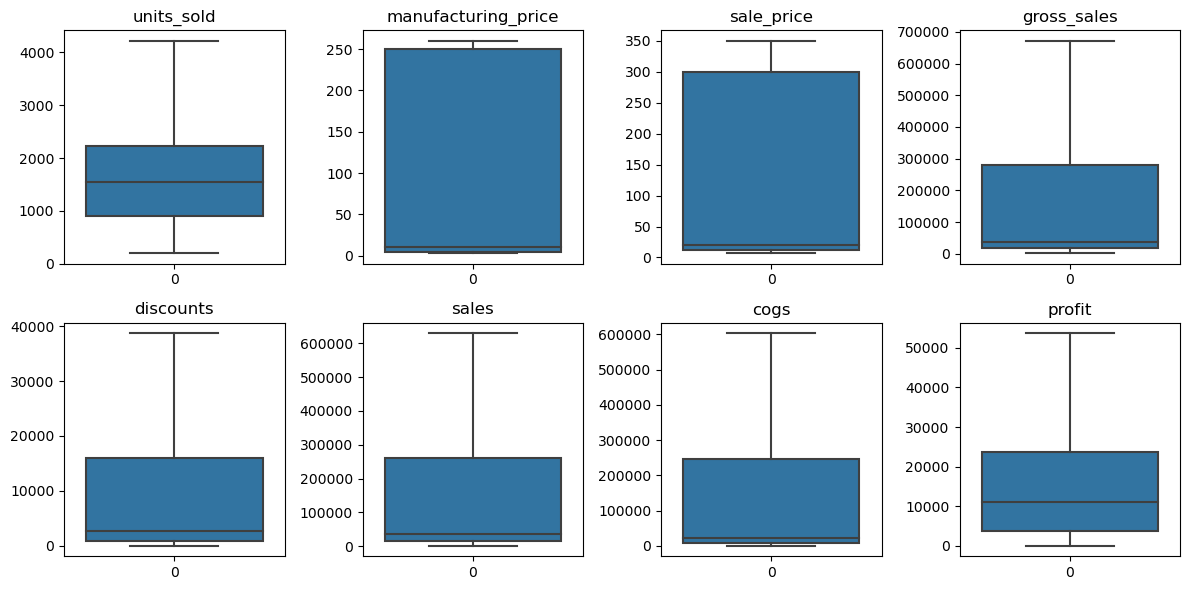

In [114]:
# Box Plots to visualize the distribution and detect outliers

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

for i, column in enumerate(['units_sold', 'manufacturing_price', 'sale_price', 'gross_sales', 'discounts', 'sales', 'cogs', 'profit']):
    plt.subplot(2, 4, i+1)
    sns.boxplot(df[column])
    plt.title(column)

plt.tight_layout()
plt.show()


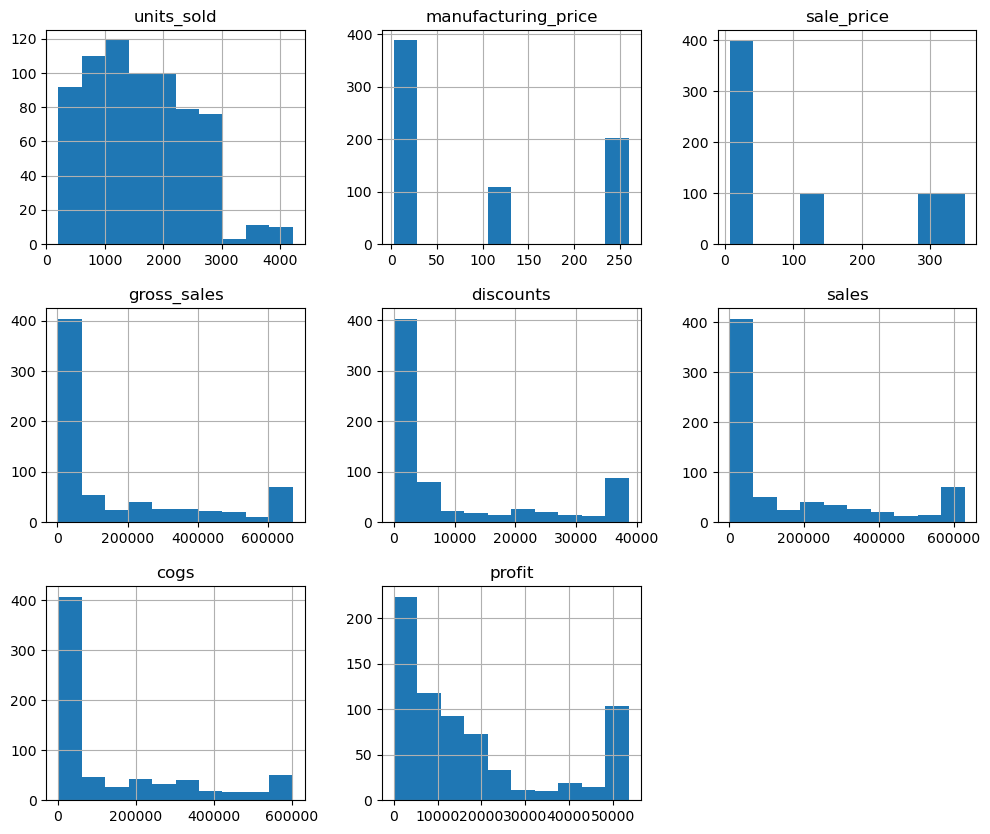

In [115]:
# Histograms for understanding the distribution of numeric variables
df[['units_sold', 'manufacturing_price', 'sale_price', 'gross_sales', 'discounts', 'sales', 'cogs', 'profit']].hist(figsize=(12, 10))
plt.show()


# Sales Performance Analysis


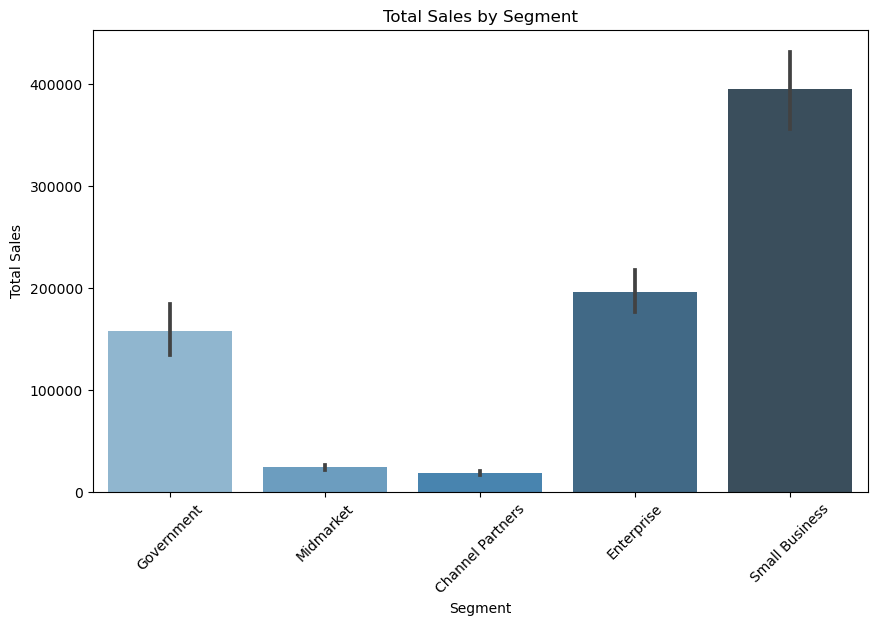

In [139]:
# Sales by Segment


plt.figure(figsize=(10, 6))
sns.barplot(x='segment', y='sales', data=df, palette='Blues_d')
plt.title('Total Sales by Segment')
plt.xticks(rotation=45)
plt.xlabel('Segment')
plt.ylabel('Total Sales')
plt.show()

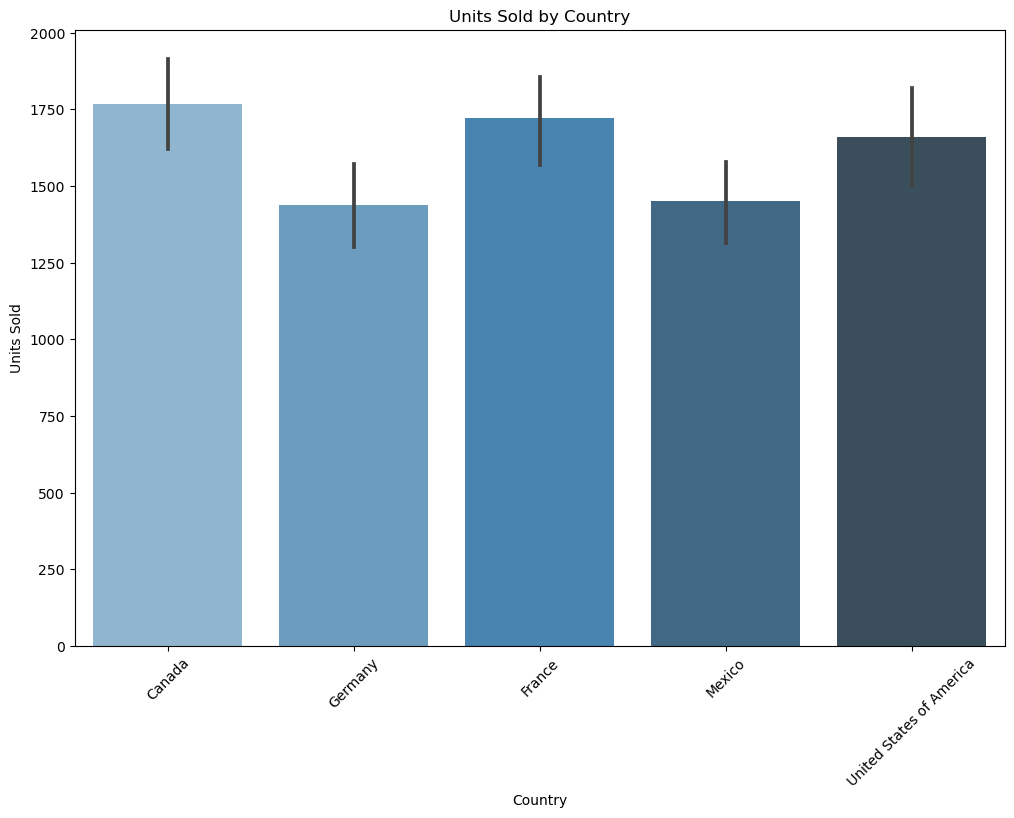

In [140]:
# Units Sold by Country
plt.figure(figsize=(12, 8))
sns.barplot(x='country', y='units_sold', data=df, palette='Blues_d')
plt.title('Units Sold by Country')
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.ylabel('Units Sold')
plt.show()



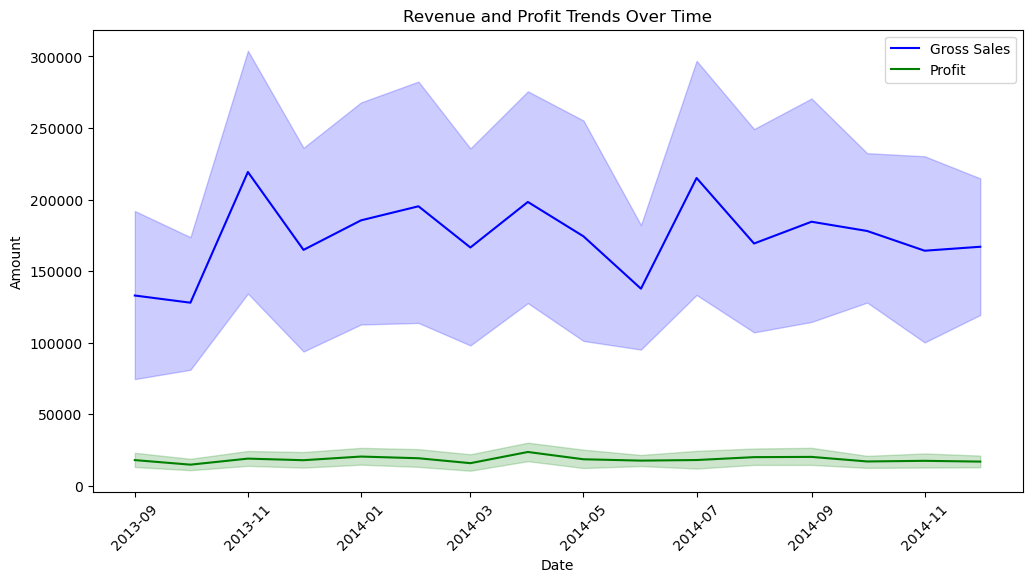

In [141]:
# Revenue and Profit Trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='gross_sales', data=df, label='Gross Sales', color='blue')
sns.lineplot(x='date', y='profit', data=df, label='Profit', color='green')
plt.title('Revenue and Profit Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.show()


# Pricing and Cost Analysis

C:\Users\AKKem\AppData\Local\Temp\ipykernel_4268\2277719697.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='sale_price', y='profit', data=df, palette='Blues_d')


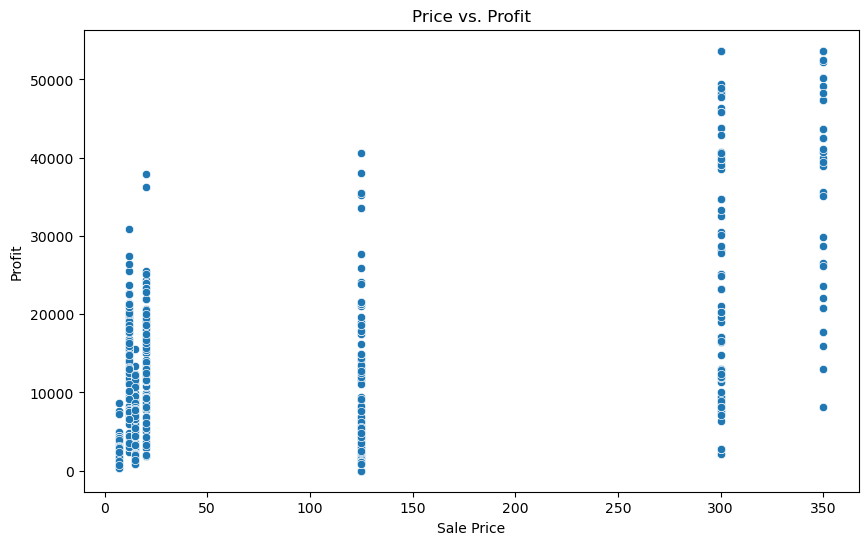

In [142]:
# Price vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sale_price', y='profit', data=df, palette='Blues_d')
plt.title('Price vs. Profit')
plt.xlabel('Sale Price')
plt.ylabel('Profit')
plt.show()


C:\Users\AKKem\AppData\Local\Temp\ipykernel_4268\3185490145.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='manufacturing_price', y='sale_price', data=df, palette='Blues_d')


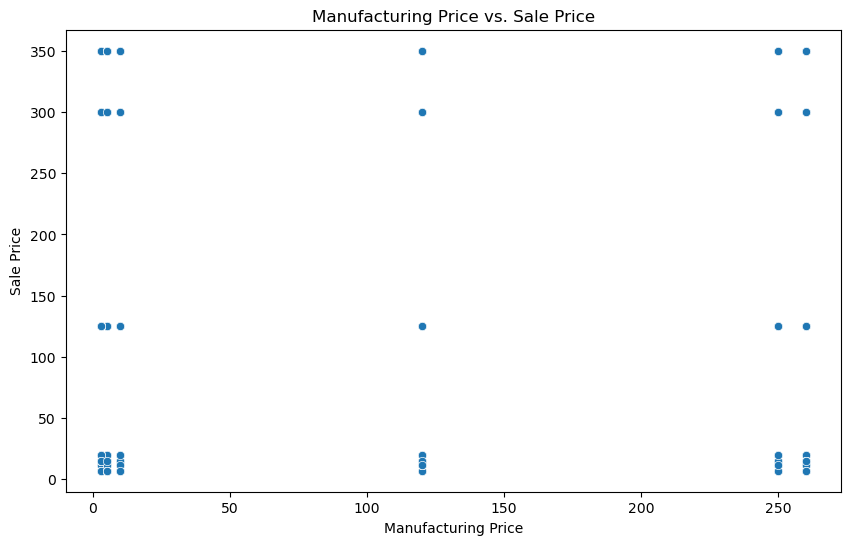

In [143]:
# Manufacturing Price vs. Sale Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='manufacturing_price', y='sale_price', data=df, palette='Blues_d')
plt.title('Manufacturing Price vs. Sale Price')
plt.xlabel('Manufacturing Price')
plt.ylabel('Sale Price')
plt.show()


# Discount Impact Analysis

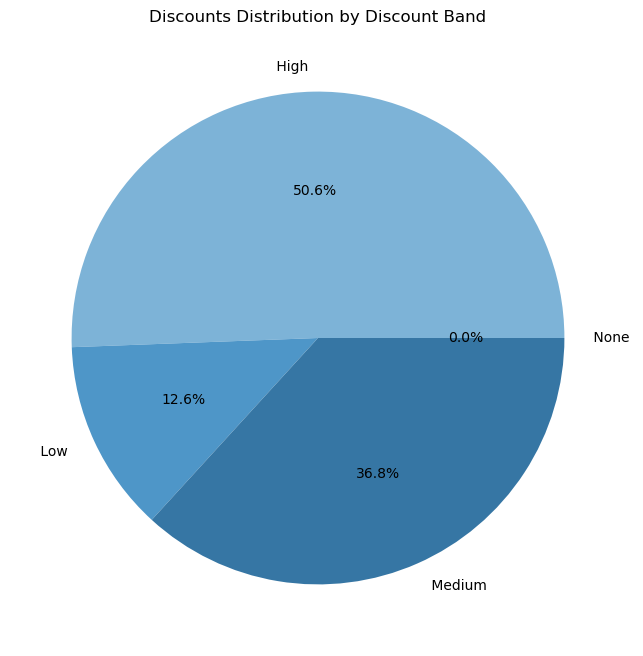

In [152]:
# Discounts vs. Sales
# Calculate total discounts by discount band
discounts_by_band = df.groupby('discount_band')['discounts'].sum()

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.pie(discounts_by_band, labels=discounts_by_band.index, autopct='%1.1f%%', colors=sns.color_palette('Blues_d', len(discounts_by_band)))
plt.title('Discounts Distribution by Discount Band')
plt.show()


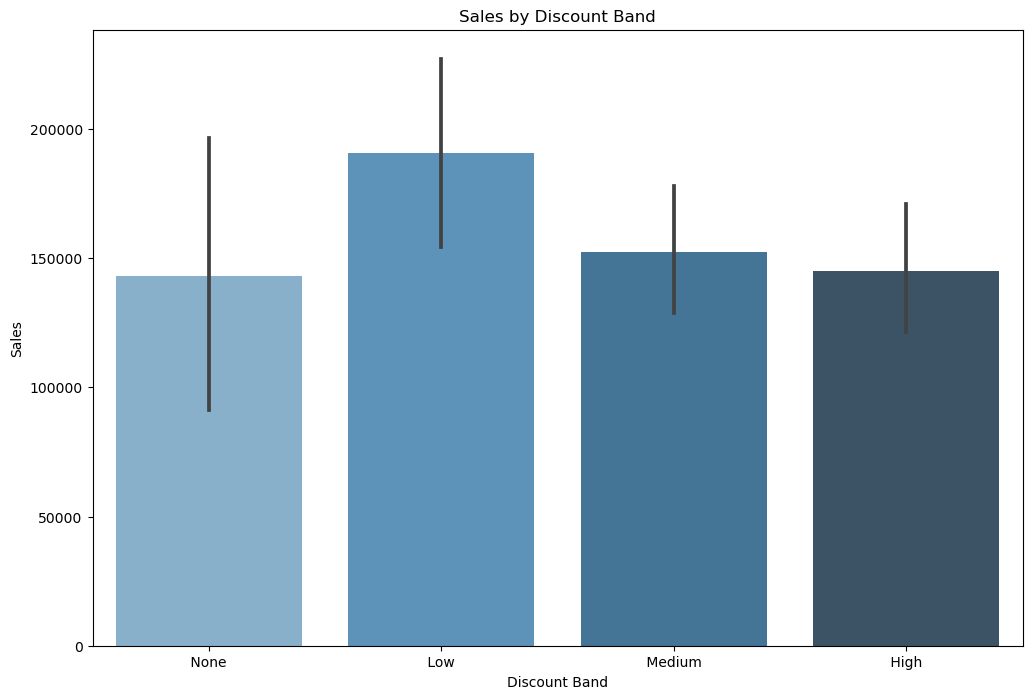

In [145]:
# Discount Band Performance
plt.figure(figsize=(12, 8))
sns.barplot(x='discount_band', y='sales', data=df, palette='Blues_d')
plt.title('Sales by Discount Band')
plt.xlabel('Discount Band')
plt.ylabel('Sales')
plt.show()

# Product Performance

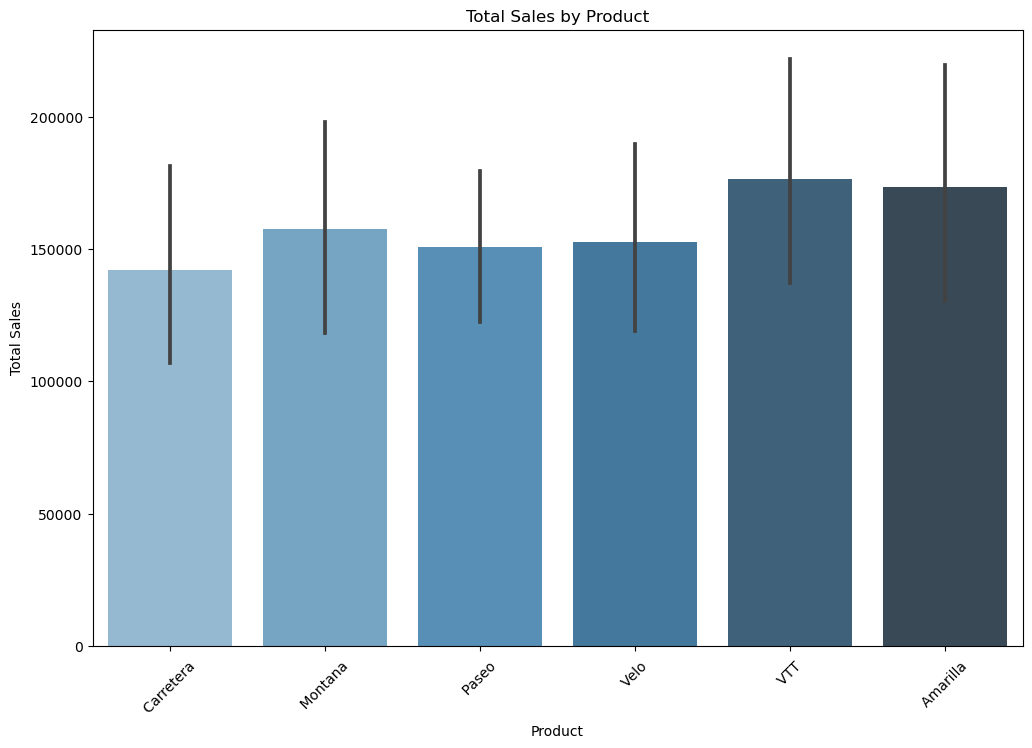

In [146]:
# Product Contribution
plt.figure(figsize=(12, 8))
sns.barplot(x='product', y='sales', data=df, palette='Blues_d')
plt.title('Total Sales by Product')
plt.xticks(rotation=45)
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.show()


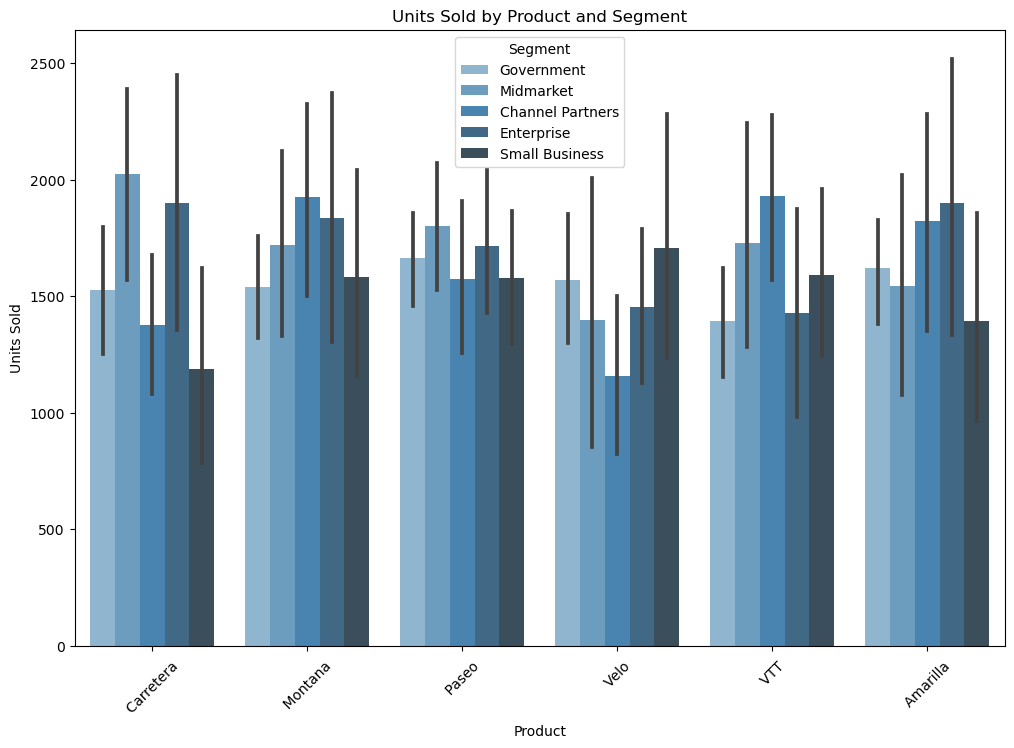

In [147]:
# Product Sales by Segment
plt.figure(figsize=(12, 8))
sns.barplot(x='product', y='units_sold', hue='segment', data=df, palette='Blues_d')
plt.title('Units Sold by Product and Segment')
plt.xticks(rotation=45)
plt.xlabel('Product')
plt.ylabel('Units Sold')
plt.legend(title='Segment')
plt.show()


# Monthly and Yearly Trends

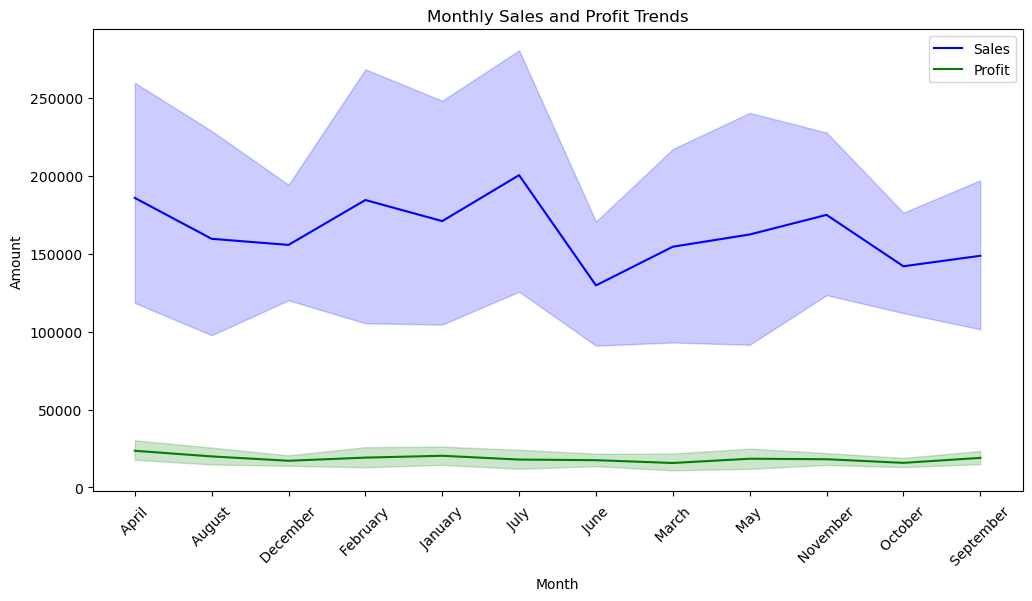

In [148]:
# Monthly Sales and Profit Trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_name', y='sales', data=df, label='Sales', color='blue')
sns.lineplot(x='month_name', y='profit', data=df, label='Profit', color='green')
plt.title('Monthly Sales and Profit Trends')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.show()


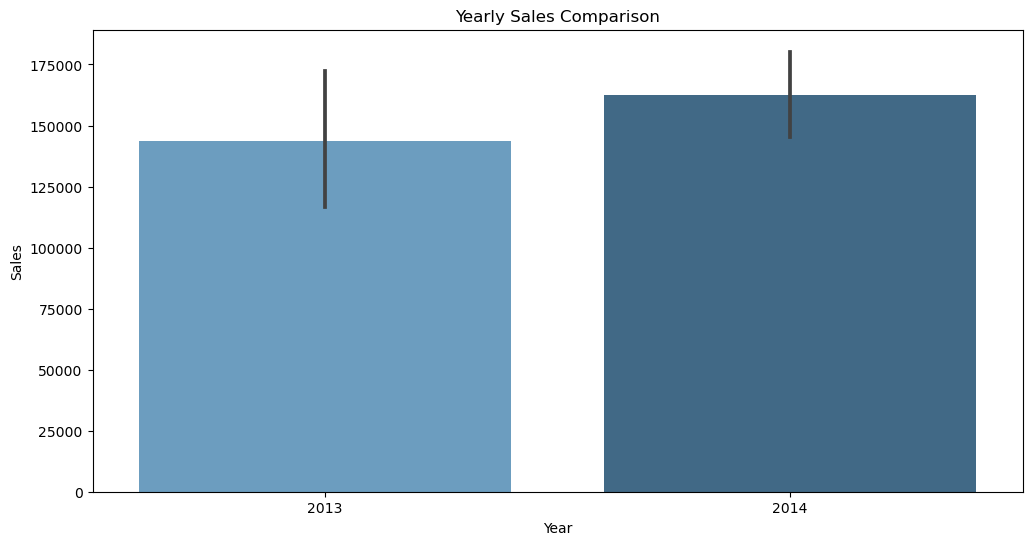

In [149]:
# Yearly Performance Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='sales', data=df, palette='Blues_d')
plt.title('Yearly Sales Comparison')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()


# Cost and Profitability Analysis

C:\Users\AKKem\AppData\Local\Temp\ipykernel_4268\1724934398.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='cogs', y='profit', data=df, palette='Blues_d')


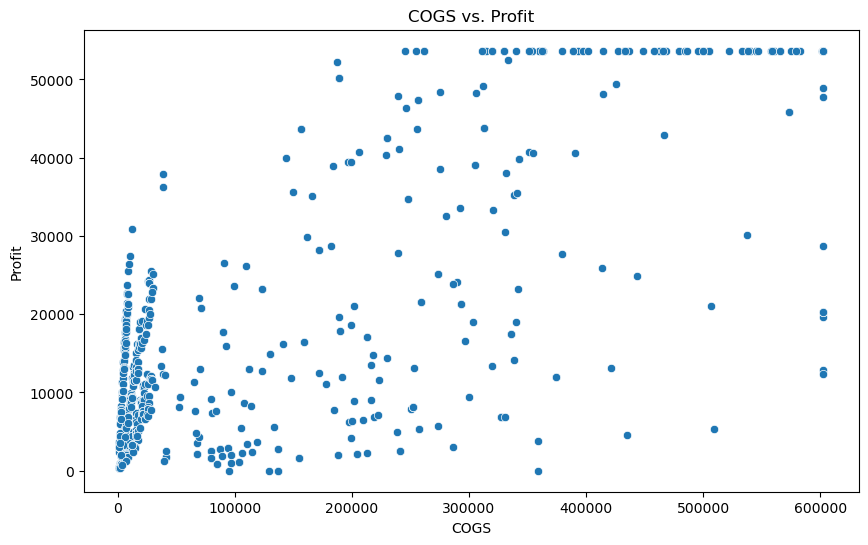

In [150]:
# COGS vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cogs', y='profit', data=df, palette='Blues_d')
plt.title('COGS vs. Profit')
plt.xlabel('COGS')
plt.ylabel('Profit')
plt.show()


C:\Users\AKKem\AppData\Local\Temp\ipykernel_4268\1117458660.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='gross_sales', y='profit', data=df, palette='Blues_d')


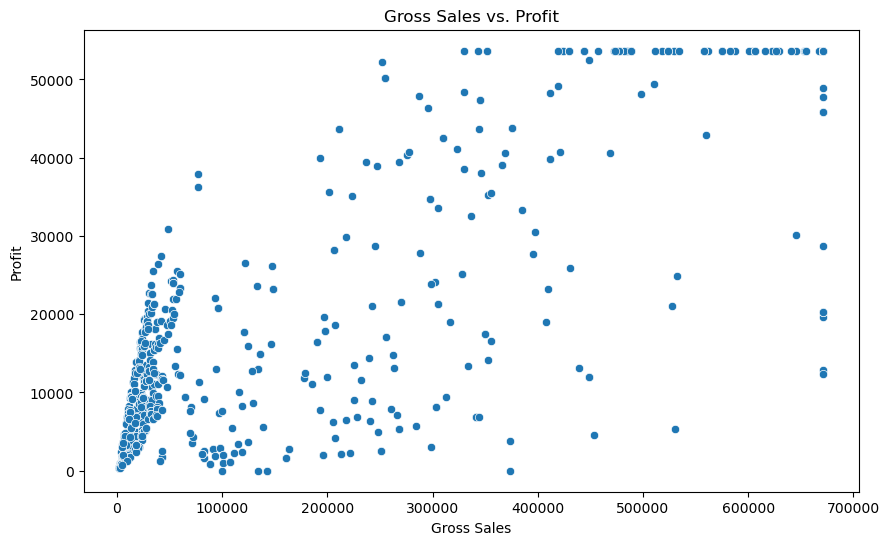

In [151]:
# Gross Sales vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gross_sales', y='profit', data=df, palette='Blues_d')
plt.title('Gross Sales vs. Profit')
plt.xlabel('Gross Sales')
plt.ylabel('Profit')
plt.show()